# Exercise 5: Use `Flux` for Logistic Regression

1. Ge the `Churn_Modelling.csv` data that was used to present the GLM package. The data is available at [https://github.com/selva86/datasets/tree/master](https://github.com/selva86/datasets/tree/master)
2. Follow the stpes described in the Flux Demos and in the GLM demos shown during the sessions
3. Evaluate the accuracy of the model's prediction, using a confusion matrix and a ROC curve
4. Submit your project followint the submission guidelines

## Solucion

Para esto me basé en las siguientes páginas:

```
https://juliastats.org/GLM.jl/stable/ 
https://fluxml.ai/Flux.jl/stable/tutorials/logistic_regression/
```

Notar que ``` Surname, Goegraphy, Gender, HasCrCard, IsActiveMember ``` son variables categóricas; algunas ya codificadas como numéricas

### Primero lo hacemos en GLM



Ver  [https://discourse.julialang.org/t/how-to-permute-the-rows-of-a-dataframe-in-place-efficiently/8825](https://discourse.julialang.org/t/how-to-permute-the-rows-of-a-dataframe-in-place-efficiently/8825) para la idea para el train-test split

Otra opción que no tomé para el train-test split está dada por la librería `MLDataPattern.jl`[https://mldatapatternjl.readthedocs.io/en/latest/documentation/datasubset.html](https://mldatapatternjl.readthedocs.io/en/latest/documentation/datasubset.html)

In [ ]:
import DataFrames, Plots, GLM, ROCAnalysis, CSV, StatsBase
using ROCAnalysis
df = DataFrames.DataFrame( CSV.File("DATA/Churn_Modelling.csv"))
println(first(df,1))
size(df)
println(size(df))
#TODO: Podríamos hacer el One-hot encoding para las categóricas como :Gender y :Geography...
DataFrames.select!(df, DataFrames.Not([:RowNumber, :Surname, :CustomerId, :Geography, :Gender]))
println(first(df,2))
println(DataFrames.describe(df))

1×14 DataFrame
 Row │ RowNumber  CustomerId  Surname   CreditScore  Geography  Gender   Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited 
     │ Int64      Int64       String31  Int64        String7    String7  Int64  Int64   Float64  Int64          Int64      Int64           Float64          Int64  
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │         1    15634602  Hargrave          619  France     Female      42       2      0.0              1          1               1        1.01349e5       1
(10000, 14)
2×9 DataFrame
 Row │ CreditScore  Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited 
     │ Int64        Int64  Int64   Float64  Int64          Int64      Int64           Float64          Int64  
─────┼────────────────────────────────────────────────────────────────────────────

In [ ]:
"""
dfX and dfy are the parts of the matrix with the variables to predict and the predicted variable.
dfX and dfy must be DataFrames; not Arrays, since we use the names
It outputs matrices Xtrain, Xtest and arrays ytrain and ytest.
"""
function MyTrainTestSplit(dfX, dfy; percentage=0.7)
    dfs = df[StatsBase.shuffle(1:size(df,1)), : ] #The df, but shuffled
    namesX=names(dfX)
    namesy=names(dfy)
    n = size(dfs,1) #same as size(dfs)[1]
    a=convert(Int, floor(n*percentage)) #convert is necesary, since floor returns a float, and indices require integers
    #println(first(dfs, 3))
    X = Matrix(dfX)
    y = Array(dfy)
    Xtrain, Xtest, ytrain, ytest=X[begin:a, :], X[(a+1):end, :], y[begin:a, :], y[(a+1):end, :]
    return DataFrames.DataFrame(Xtrain, namesX), DataFrames.DataFrame(Xtest,namesX), DataFrames.DataFrame(ytrain,namesy), DataFrames.DataFrame(ytest,namesy)
end
Xtrain, Xtest, ytrain, ytest = MyTrainTestSplit(df[:, 1:8], df[:, 9:9]; percentage=0.7)
dftrain = hcat(Xtrain,ytrain)
first(dftrain)

Row,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,619.0,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1


In [ ]:
Model = GLM.glm(@GLM.formula(Exited ~ CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard +IsActiveMember + EstimatedSalary),
                  dftrain, GLM.Binomial(), GLM.LogitLink())

StatsModels.TableRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Distributions.Binomial{Float64}, GLM.LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Exited ~ 1 + CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error       z  Pr(>|z|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -3.88117      0.284123    -13.66    <1e-41  -4.43804     -3.3243
CreditScore      -0.000530989  0.00032802   -1.62    0.1055  -0.0011739    0.000111917
Age               0.0756213    0.00306864   24.64    <1e-99   0.0696069    0.0816357
Tenure           -0.00921721   0.0110308    -0.84    0.4034  -0.0308371    0.0124027
Balance        

In [ ]:
Probstest = GLM.predict(Model,Xtest)

3000-element Vector{Union{Missing, Float64}}:
 0.1466006996454466
 0.48064869630341617
 0.20856687853976863
 0.3955989862892792
 0.25474529777050076
 0.3692529835951049
 0.05204334951462009
 0.19415041984715434
 0.7646467221509675
 0.03445578429631856
 ⋮
 0.5320367723039365
 0.17679302493068322
 0.17684072223324002
 0.10670915535476287
 0.1898965599432262
 0.07655019828384155
 0.06063476784094307
 0.29457543208631826
 0.15507842546124664

In [ ]:
df3 =hcat(DataFrames.DataFrame(Matrix(reshape(Probstest,(:,1))),[:predicted]),ytest)
tar= df3[(df3.Exited .==1),:].predicted
non= df3[(df3.Exited .==0),:].predicted


2406-element Vector{Union{Missing, Float64}}:
 0.1466006996454466
 0.48064869630341617
 0.20856687853976863
 0.25474529777050076
 0.3692529835951049
 0.05204334951462009
 0.19415041984715434
 0.03445578429631856
 0.1674169160644095
 0.08292787196445568
 ⋮
 0.1045595946104502
 0.03254481913492744
 0.15676587867122474
 0.17679302493068322
 0.17684072223324002
 0.10670915535476287
 0.1898965599432262
 0.07655019828384155
 0.15507842546124664

In [ ]:
r = ROCAnalysis.roc(tar, non)


ROC curve with 840 points, of which 26 on the convex hull

In [ ]:
df_r=DataFrames.DataFrame(r)

Row,pfa,pmiss,thres,chull,llr
,Float64,Float64,Float64?,Bool,Float64?
1,1.0,0.0,0.0159377,true,-Inf
2,0.999584,0.0,0.0169856,true,-2.50649
3,0.999584,0.0016835,0.0171823,false,-2.50649
4,0.997091,0.0016835,0.0223947,false,-2.50649
5,0.997091,0.003367,0.0225563,false,-2.50649
6,0.986284,0.003367,0.0290069,false,-2.50649
7,0.986284,0.00505051,0.0290175,false,-2.50649
8,0.937656,0.00505051,0.0418736,true,-1.73665
9,0.937656,0.00673401,0.0419394,false,-1.73665


In [ ]:
df_r=DataFrames.DataFrame(r)
df_r.phit=1 .- df_r.pmiss
df_r.phit_minus_pfa = df_r.phit .- df_r.pfa
println(maximum(df_r.phit_minus_pfa)) 
rmax=argmax(df_r.phit_minus_pfa) #The row with the best threshold
df_r[rmax,:]

0.3415199375299126


Row,pfa,pmiss,thres,chull,llr,phit,phit_minus_pfa
,Float64,Float64,Float64?,Bool,Float64?,Float64,Float64
356,0.315046,0.343434,0.208459,true,0.0551068,0.656566,0.34152


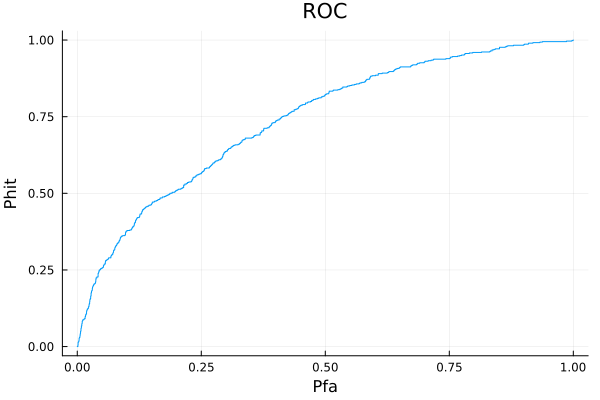

In [ ]:
Plots.plot(r,traditional=true)

In [ ]:
println(ROCAnalysis.AUC(r)) #The one in the package

0.7386716989792634


### Ahora con Flux

In [ ]:
import DataFrames, Plots, Flux, ROCAnalysis, CSV, StatsBase
using ROCAnalysis
df = DataFrames.DataFrame( CSV.File("DATA/Churn_Modelling.csv"))
println(first(df,1))
size(df)
println(size(df))
#TODO: Podríamos hacer el One-hot encoding para las categóricas como :Gender y :Geography...
DataFrames.select!(df, DataFrames.Not([:RowNumber, :Surname, :CustomerId, :Geography, :Gender]))
println(first(df,2))
println(DataFrames.describe(df))

1×14 DataFrame
 Row │ RowNumber  CustomerId  Surname   CreditScore  Geography  Gender   Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited 
     │ Int64      Int64       String31  Int64        String7    String7  Int64  Int64   Float64  Int64          Int64      Int64           Float64          Int64  
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │         1    15634602  Hargrave          619  France     Female      42       2      0.0              1          1               1        1.01349e5       1
(10000, 14)
2×9 DataFrame
 Row │ CreditScore  Age    Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited 
     │ Int64        Int64  Int64   Float64  Int64          Int64      Int64           Float64          Int64  
─────┼────────────────────────────────────────────────────────────────────────────

In [ ]:
"""
dfX and dfy are the parts of the matrix with the variables to predict and the predicted variable.
dfX and dfy must be DataFrames; not Arrays, since we use the names
It outputs matrices Xtrain, Xtest and arrays ytrain and ytest.
"""
function MyTrainTestSplit(dfX, dfy; percentage=0.1)
    dfs = df[StatsBase.shuffle(1:size(df,1)), : ] #The df, but shuffled
    namesX=names(dfX)
    namesy=names(dfy)
    n = size(dfs,1) #same as size(dfs)[1]
    a=convert(Int, floor(n*percentage)) #convert is necesary, since floor returns a float, and indices require integers
    #println(first(dfs, 3))
    X = Matrix(dfX)
    y = Array(dfy)
    Xtrain, Xtest, ytrain, ytest=X[begin:a, :], X[(a+1):end, :], y[begin:a, :], y[(a+1):end, :]
    return DataFrames.DataFrame(Xtrain, namesX), DataFrames.DataFrame(Xtest,namesX), DataFrames.DataFrame(ytrain,namesy), DataFrames.DataFrame(ytest,namesy)
end
Xtrain, Xtest, ytrain, ytest = MyTrainTestSplit(df[:, 1:8], df[:, 9:9]; percentage=0.7)
dftrain = hcat(Xtrain,ytrain)
first(dftrain)

Row,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,619.0,42.0,2.0,0.0,1.0,1.0,1.0,1.01349e5,1


In [ ]:
# For some reason Flux works with the transpose (See the example in fluxml.ai)
xtr=transpose(Matrix(Xtrain))
ytr=transpose(Matrix(ytrain));

In [ ]:
flux_model = Flux.Chain(Flux.Dense(8=>1), Flux.softmax)

Chain(
  Dense(8 => 1),                        # 9 parameters
  NNlib.softmax,
) 

In [ ]:
flux_model[1].weight, flux_model[1].bias

(Float32[-0.15190633 -0.54236186 … 0.55877113 -0.6036631], Float32[0.0])

In [ ]:
custom_logitcrossentropy(yhat, y) = Flux.mean(.-sum(yhat .* Flux.logsoftmax(yhat; dims=1); dims=1))

custom_logitcrossentropy (generic function with 1 method)

In [ ]:
function custom_loss(weights, biases, features, labels_onehot)
    yhat = custom_model(weights, biases, features)
    custom_logitcrossentropy(yhat, labels_onehot)
end;
custom_loss(W, b, xtr, ytr)

NaN32

In [ ]:
df3 =hcat(DataFrames.DataFrame(Matrix(reshape(Probstest,(:,1))),[:predicted]),ytest)
tar= df3[(df3.Exited .==1),:].predicted
non= df3[(df3.Exited .==0),:].predicted


2406-element Vector{Union{Missing, Float64}}:
 0.1466006996454466
 0.48064869630341617
 0.20856687853976863
 0.25474529777050076
 0.3692529835951049
 0.05204334951462009
 0.19415041984715434
 0.03445578429631856
 0.1674169160644095
 0.08292787196445568
 ⋮
 0.1045595946104502
 0.03254481913492744
 0.15676587867122474
 0.17679302493068322
 0.17684072223324002
 0.10670915535476287
 0.1898965599432262
 0.07655019828384155
 0.15507842546124664

In [ ]:
r = ROCAnalysis.roc(tar, non)


ROC curve with 840 points, of which 26 on the convex hull

In [ ]:
df_r=DataFrames.DataFrame(r)

Row,pfa,pmiss,thres,chull,llr
,Float64,Float64,Float64?,Bool,Float64?
1,1.0,0.0,0.0159377,true,-Inf
2,0.999584,0.0,0.0169856,true,-2.50649
3,0.999584,0.0016835,0.0171823,false,-2.50649
4,0.997091,0.0016835,0.0223947,false,-2.50649
5,0.997091,0.003367,0.0225563,false,-2.50649
6,0.986284,0.003367,0.0290069,false,-2.50649
7,0.986284,0.00505051,0.0290175,false,-2.50649
8,0.937656,0.00505051,0.0418736,true,-1.73665
9,0.937656,0.00673401,0.0419394,false,-1.73665


In [ ]:
df_r=DataFrames.DataFrame(r)
df_r.phit=1 .- df_r.pmiss
df_r.phit_minus_pfa = df_r.phit .- df_r.pfa
println(maximum(df_r.phit_minus_pfa)) 
rmax=argmax(df_r.phit_minus_pfa) #The row with the best threshold
df_r[rmax,:]

0.3415199375299126


Row,pfa,pmiss,thres,chull,llr,phit,phit_minus_pfa
,Float64,Float64,Float64?,Bool,Float64?,Float64,Float64
356,0.315046,0.343434,0.208459,true,0.0551068,0.656566,0.34152


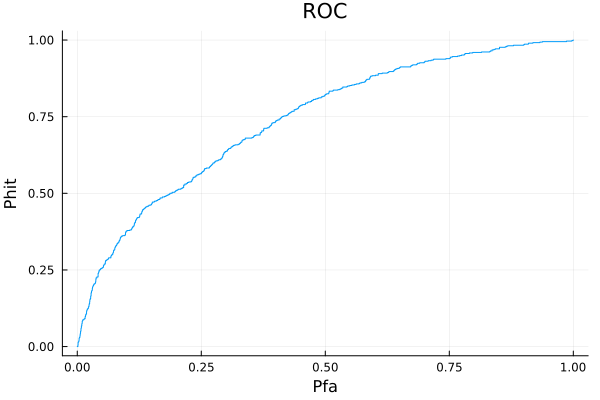

In [ ]:
Plots.plot(r,traditional=true)

In [ ]:
println(ROCAnalysis.AUC(r)) #The one in the package

0.7386716989792634
